In [1]:
import lnpy

In [2]:
?lnpy.Segmenter.peaks

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import xarray as xr
import pandas as pd
import lnpy

In [2]:
# function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError("bad tag function")
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)

In [4]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm


def get_bin_spin1(lnz2, phase_creator, from_builder, from_builder_kws=None):
    build_phases = phase_creator.build_phases_mu([None, lnz2])
    lnzs = np.linspace(-8, 8, 20)
    if from_builder_kws is None:
        from_builder_kws = {}
    c = from_builder(lnzs, build_phases, **from_builder_kws)
    t_spin = None
    t_bino = None

    try:
        c.spinodal(2, build_phases, inplace=True, unstack=False)
        c.binodal(2, build_phases, inplace=True, unstack=False)
        t_spin = c.spinodal.access.xge.table(["molfrac"], ref=ref)
        t_bino = c.binodal.access.xge.table(["molfrac"], ref=ref)
    except:
        pass
    return t_spin, t_bino

# Bulk

In [11]:
ref_bulk = (
    lnpy.lnPiMasked.from_table(
        "./nahs_asym_mix.07_07_07.r1.lnpi_o.dat",
        lnz=np.array([0.5, 0.5]),
        state_kws={"beta": 1.0, "volume": 1.0},
    )
    .zeromax()
    .pad()
)

phase_creator_bulk = lnpy.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref_bulk, tag_phases=tag_phases2, merge_kws=dict(efac=0.8)
)

In [12]:
ref = ref_bulk
phase_creator = phase_creator_bulk

In [13]:
out1 = Parallel(n_jobs=-1)(
    delayed(get_bin_spin1)(lnz2, phase_creator, lnpy.lnPiCollection.from_builder)
    for lnz2 in np.arange(-5, 5, 0.5)
)
spin1 = xr.concat([s for s, b in out1 if s is not None], "sample")
bino1 = xr.concat([b for s, b in out1 if b is not None], "sample")

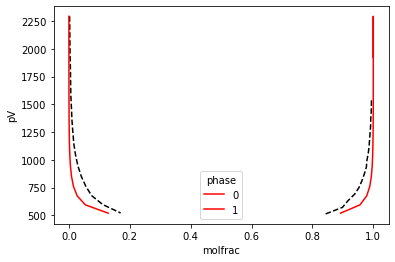

In [14]:
def plot_frame(df, **kws):
    (
        df.reset_index()
        .set_index(["molfrac", "phase"])
        .assign(pV=lambda x: x["betapV"] / x["beta"])["pV"]
        .to_xarray()
        .plot(hue="phase", **kws)
    )


plot_frame(
    spin1.reset_index("sample")
    .to_dataframe()
    .query("component==0 and spinodal==phase")
    .dropna(),
    ls="--",
    color="k",
)
plot_frame(
    bino1.reset_index("sample").to_dataframe().query("component==0").dropna(), color="r"
)

# Conf

In [50]:
ref_conf = lnPi.MaskedlnPiDelayed.from_table(
    "./nahs_asym_mix.11_11_03.r1.lnpi_o.dat",
    lnz=[0.5, 0.5],
    state_kws=dict(beta=1.0, volume=1.0),
).pad()
phase_creator_conf = lnPi.segment.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref_conf, tag_phases=tag_phases2, merge_kws=dict(efac=0.8)
)

In [51]:
ref = ref_conf
phase_creator = phase_creator_conf

In [38]:
out1 = Parallel(n_jobs=-1, backend="multiprocessing")(
    delayed(get_bin_spin1)(lnz2, phase_creator, lnPi.CollectionlnPi.from_builder)
    for lnz2 in tqdm(np.arange(-5, 5, 0.1))
)


spin1 = xr.concat([s for s, b in out1 if s is not None], "sample")
bino1 = xr.concat([b for s, b in out1 if b is not None], "sample")

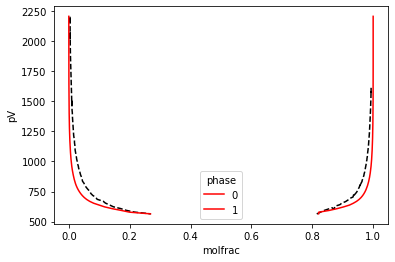

In [39]:
def plot_frame(df, **kws):
    (
        df.reset_index()
        .set_index(["molfrac", "phase"])
        .assign(pV=lambda x: x["betapV"] / x["beta"])["pV"]
        .to_xarray()
        .plot(hue="phase", **kws)
    )


plot_frame(
    spin1.reset_index("sample")
    .to_dataframe()
    .query("component==0 and spinodal==phase")
    .dropna(),
    ls="--",
    color="k",
)
plot_frame(
    bino1.reset_index("sample").to_dataframe().query("component==0").dropna(), color="r"
)

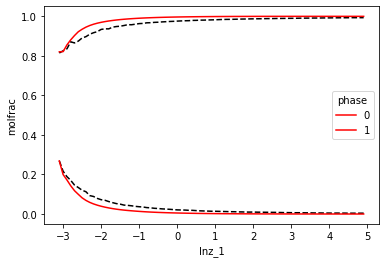

In [40]:
def plot_frame(df, **kws):
    (
        df.reset_index()
        .set_index(["lnz_1", "phase"])
        .assign(pV=lambda x: x["betapV"] / x["beta"])["molfrac"]
        .to_xarray()
        .plot(hue="phase", **kws)
    )


plot_frame(
    spin1.reset_index("sample")
    .to_dataframe()
    .query("component==0 and spinodal==phase")
    .dropna(),
    ls="--",
    color="k",
)
plot_frame(
    bino1.reset_index("sample").to_dataframe().query("component==0").dropna(), color="r"
)

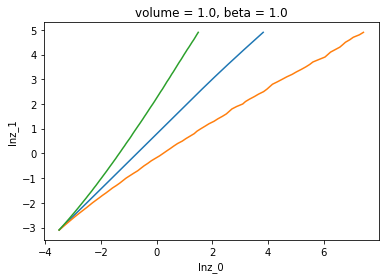

In [41]:
bino1.sel(binodal=0).lnz_1.reset_index("sample").swap_dims({"sample": "lnz_0"}).plot()

for s in [0, 1]:
    (
        spin1.lnz_1.pipe(lambda x: x.sel(sample=x.spinodal == x.phase))
        .sel(spinodal=s)
        .reset_index("sample")
        .swap_dims({"sample": "lnz_0"})
        .plot()
        #     .reset_index('sample')
        #     .set_index(sample=['lnz_0','spinodal'])
        #     .unstack('sample')
        #     .plot(hue='spinodal')
        #    .swap_dims({'sample':'lnz_0'})
    )

/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/xarray/plot/plot.py:86: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  yplt = darray.transpose(xdim, huedim)


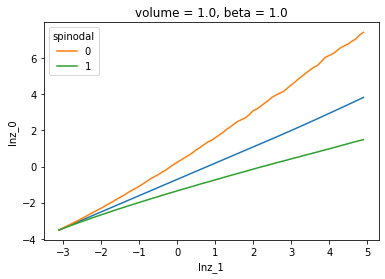

In [42]:
(bino1.lnz_0.reset_index(["lnz_0", "phase"]).sel(binodal=0).plot())

(
    spin1.lnz_0.pipe(lambda x: x.sel(sample=x.spinodal == x.phase))
    .reset_index(["lnz_0", "phase"])
    .unstack("sample")
    .plot(hue="spinodal")
)

# Mol fraction

In [ ]:
import lnPi.molfrac

In [247]:
from importlib import reload

reload(lnPi.molfrac)

In [349]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

phase_creator = phase_creator_bulk


def get_stuff(lnz_1, mfs):
    x = np.linspace(-10.0, +10.0, 20)
    build_phases = phase_creator.build_phases_mu([None, lnz_1])
    c = lnPi.CollectionlnPi.from_builder(x, build_phases, unstack=True)
    L = []

    for mf in mfs:
        try:
            out, r = lnPi.molfrac.find_lnz_molfrac(
                mf,
                c,
                build_phases=build_phases,
                phase_id=0,
                component=0,
                ntry=20,
                dfac=1.5,
            )
            L.append(out)
        except:
            pass
    return L

In [350]:
mfs = [0.0025, 0.005, 0.01, 0.02, 0.04, 0.05, 0.08, 0.1]

x1 = np.arange(-10.0, -5.0, 0.2)
x2 = np.arange(-5.0, 4.01, 0.05)

seq = np.concatenate((x1, x2))
seq = np.round(seq, 2)
mfs = np.array(mfs)

In [353]:
with lnPi.set_options(tqdm_bar="text", tqdm_leave=True, joblib_use=False):
    L = Parallel(n_jobs=-1, backend="multiprocessing")(
        delayed(get_stuff)(lnz_1, mfs) for lnz_1 in tqdm(seq[:])
    )

In [354]:
LL = sum(L, [])
c_bulk = lnPi.CollectionlnPi.concat(LL, unstack=True)

In [355]:
table_bulk = (
    c_bulk.xge.table(
        ["molfrac", "mask_stable", "betapV", "dens"],
        default_keys=[],
        dim_to_suffix="component",
    )
    .to_dataframe()
    .dropna()  # .query('mask_stable')
    .assign(mf_0=lambda x: np.round(x["molfrac_0"], 4))
    .assign(delta=lambda x: np.abs(x.mf_0 - x.molfrac_0))
    .reset_index()
)

In [356]:
lnzs = table_bulk[["lnz_0", "lnz_1"]].drop_duplicates().values
c_conf = lnPi.CollectionlnPi.from_builder(
    lnzs, phase_creator_conf.build_phases, unstack=True
)

In [357]:
table_conf = (
    c_conf.xge.table(
        ["nvec", "ntot"], default_keys=[], mask_stable=True, dim_to_suffix="component"
    )
    .to_dataframe()
    .reset_index()
    .dropna()
)

In [358]:
table = pd.merge(
    table_bulk, table_conf, on=["lnz_0", "lnz_1"], suffixes=["_bulk", "_conf"]
)

In [360]:
import seaborn as sns

/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


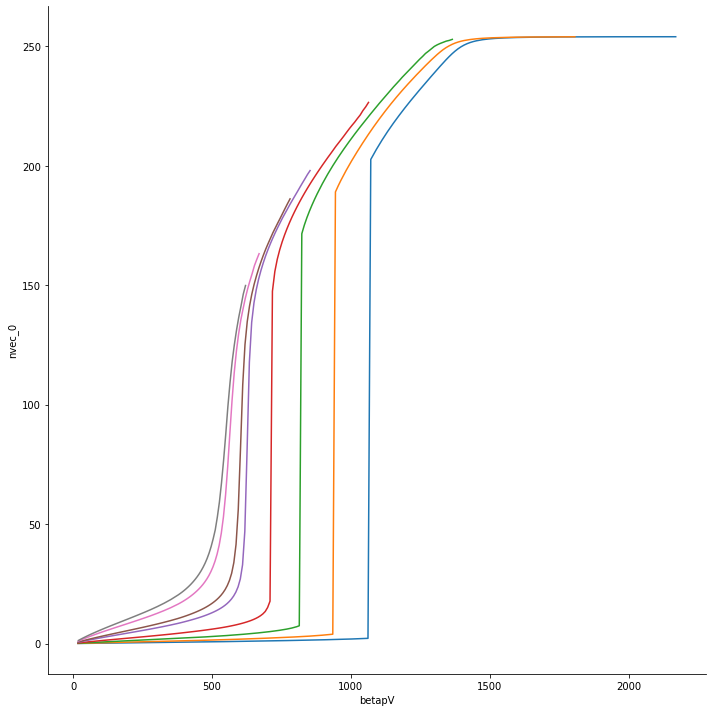

In [362]:
(
    sns.FacetGrid(table, hue="mf_0", hue_order=mfs, size=10).map(
        plt.plot, "betapV", "nvec_0"
    )
)

/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


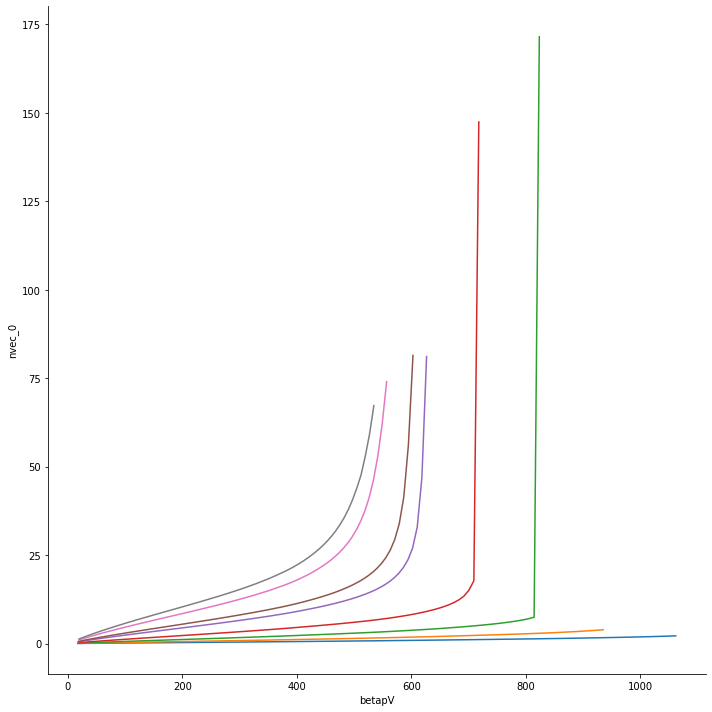

In [365]:
(
    sns.FacetGrid(table.query("mask_stable"), hue="mf_0", hue_order=mfs, size=10).map(
        plt.plot, "betapV", "nvec_0"
    )
)